In [35]:
import torch

import os

import numpy as np
import statistics

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [36]:
from preprocess import preprocess

In the next test, the network architecture was modified by adding more convolutional layers to increase model complexity and enable learning of more detailed differences.

### Preprocessing

In [37]:
dataset = torch.load("dataset.pth")

In [38]:
weights = torch.load("weights.pth")

In [39]:
trainloader,testloader,valloader = preprocess(dataset, 64)

In [40]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [41]:
tensor_example=images[0]

In [42]:
tensor_example.shape

torch.Size([1, 128, 128])

In [43]:
def show_image(tensor_img):
    plt.imshow(tensor_img.squeeze(), cmap='gray')
    plt.show()

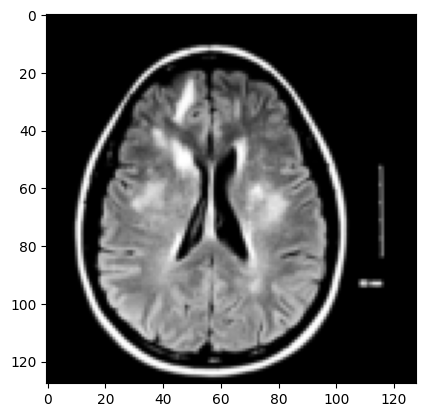

tensor(0)


In [44]:
sample_id = 5

show_image(images[sample_id])
print(labels[sample_id])

### Defining net structure

Different layer configurations were tested. Initially, more convolutional layers were added, increasing gradually with each layer the number of output channels and the kernel size, the aim was to allow the model to learn more complex patterns. However, with this dataset, using 4 convolutional layers resulted lower performance. This probably happend as dataset was too small, making it difficult for the model to effectively train a large number of parameters. So in the end this last layer was subtracted from the model. 

In the final layers dense layers were used to reduce the output size more gradually. The network was trained with a combination of layers and parameter settings, and the best results are presented in the notebook.

In [45]:
conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(16, 64, 3)
conv3 = nn.Conv2d(64, 128, 7)
# conv4 = nn.Conv2d(128, 256, 2)
fc1 = nn.Linear(256*2*2, 512)
fc3 = nn.Linear(512, 128)
fc4 = nn.Linear(128, 4)

x = tensor_example
x = pool(F.relu(conv1(x)))
# # # x=F.relu(conv2(x))
x = pool(F.relu(conv2(x)))
x = pool(F.relu(conv3(x)))
# x = pool(F.relu(conv4(x)))
# x = torch.flatten(x)
# # # x.shape
# x = F.relu(fc1(x))
# x = F.relu(fc3(x))
# x = fc4(x)
x.shape

torch.Size([128, 12, 12])

In [46]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 7)
        # self.conv4 = nn.Conv2d(128, 256, 2)

        self.fc1 = nn.Linear(128*12*12, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()

In [47]:
device = torch.device(os.getenv("DEVICE"))
net.to(device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=4, bias=True)
)

### Training

In [48]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [49]:
train_loss_plot = []
test_loss_plot = []

In [50]:
best_result = np.inf
test_loss_array = []
n_epochs = 20
patience = 3

for epoch in range(n_epochs):

    total_loss = 0
    for X_batch, y_batch in trainloader:

        X_batch = X_batch.to(device,dtype=torch.float32)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        outputs = net(X_batch)

        loss = criterion(outputs.to(device), y_batch)
        train_loss_plot.append(loss.item())

        loss.backward()
        optimizer.step()

        total_loss += loss.item() 

    test_loss = 0
    with torch.no_grad():  
            
            for X_batch, y_batch in testloader:

                X_batch = X_batch.to(device,dtype=torch.float32)
                y_batch = y_batch.to(device)

                outputs = net(X_batch)
                t_loss = criterion(outputs.to(device), y_batch)
                test_loss_plot.append(t_loss.item())

                test_loss+=t_loss

    loss = total_loss / (len(trainloader))
    loss_test = test_loss / (len(testloader))

    test_loss_array.append(loss_test)

    if loss_test < best_result:
        torch.save(net.state_dict(), "./custom_net.pth")

    print(f"Epoch: {epoch}, Train loss: {loss}, Test loss: {loss_test}")

    if len(test_loss_array)>patience+1:
        if not (any(x > (test_loss_array[-1]+0.001) for x in test_loss_array[len(test_loss_array)-patience-1:-1])):
            break

Epoch: 0, Train loss: 1.3726312909275293, Test loss: 1.3152680397033691
Epoch: 1, Train loss: 1.1197865474969149, Test loss: 1.2591544389724731
Epoch: 2, Train loss: 0.8918977165594697, Test loss: 0.7235259413719177
Epoch: 3, Train loss: 0.6551181791583076, Test loss: 0.6281047463417053
Epoch: 4, Train loss: 0.4961358020082116, Test loss: 0.4515715539455414
Epoch: 5, Train loss: 0.47437959199305624, Test loss: 0.4098469614982605
Epoch: 6, Train loss: 0.37487804470583797, Test loss: 0.8550841808319092


### Results

The model fits the training data which can be observed as a decrease in training loss (with some fluctuations but the trend is quite clear), on the other hand a the improvement in test loss is not very strong that may suggest that the model is still not perfect in capturing more general patterns, and the train and test loss gap increases at the end, with a huge spike of loss in the last epoch - which indicates overfit. On the other hand a model with additional convolutional layer further increased this problem, as the additional complexity was not suitable for a limited dataset.

The plots show the loss calculated after each batch.


<Axes: >

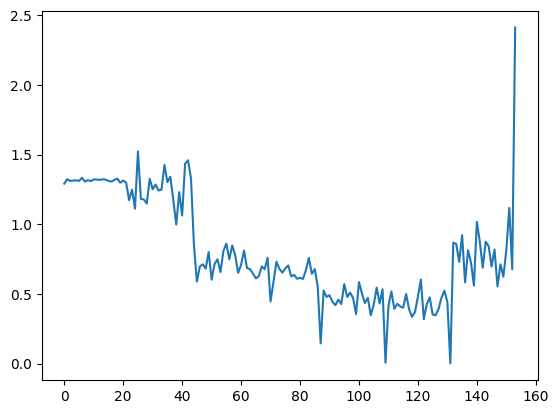

In [51]:
import seaborn as sns

sns.lineplot(data = test_loss_plot)

<Axes: >

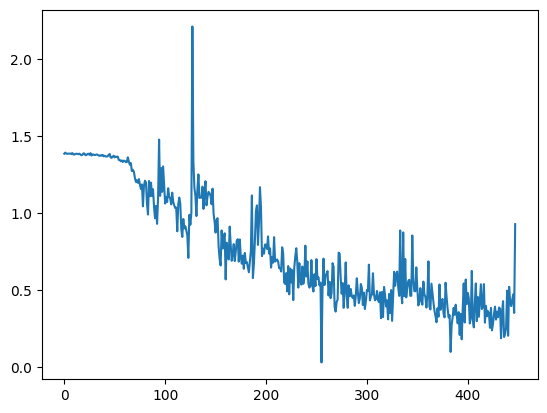

In [52]:
sns.lineplot(data = train_loss_plot)

In [57]:
net.load_state_dict(torch.load("custom_net.pth"))

<All keys matched successfully>

In [58]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [59]:
accuracy = []
f1_scr = []
precision = []
recall=[]

with torch.no_grad():
    
    for X_batch, y_batch in valloader:
        outputs_pred = net(X_batch.to(device))

        _, topi = outputs_pred.topk(1)

        topi=topi.cpu()

        acc = accuracy_score(y_batch,topi.squeeze(-1))
        f1 = f1_score(y_batch,topi.squeeze(-1), average="macro")
        pr = precision_score(y_batch,topi.squeeze(-1), average="macro")
        rec = recall_score(y_batch,topi.squeeze(-1),average="macro")


        accuracy.append(float(acc))
        f1_scr.append(float(f1))
        precision.append(float(pr))
        recall.append(float(rec))


The results decreased compared to the previous base model suggesting that the dataset may be too small for it's complexity

In [60]:
print(statistics.mean(accuracy))
print(statistics.mean(f1_scr))
print(statistics.mean(precision))
print(statistics.mean(recall))

0.6697443181818182
0.6504562397587299
0.7851681441439684
0.67700350637734
